<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/dev/aerial_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://zenodo.org/record/1154821/files/berlin.zip?download=1

--2021-02-24 07:35:17--  https://zenodo.org/record/1154821/files/berlin.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2004638627 (1.9G) [application/octet-stream]
Saving to: ‘berlin.zip?download=1’

berlin.zip?download 100%[===================>]   1.87G  24.6MB/s    in 52s     

2021-02-24 07:36:10 (36.9 MB/s) - ‘berlin.zip?download=1’ saved [2004638627/2004638627]



In [2]:
!mv 'berlin.zip?download=1' berlin.zip
!unzip -q berlin.zip -d data/

In [3]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 339 (delta 0), reused 3 (delta 0), pack-reused 334
Receiving objects: 100% (339/339), 375.41 KiB | 1.15 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [4]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [5]:
city = 'berlin'
path = 'data'

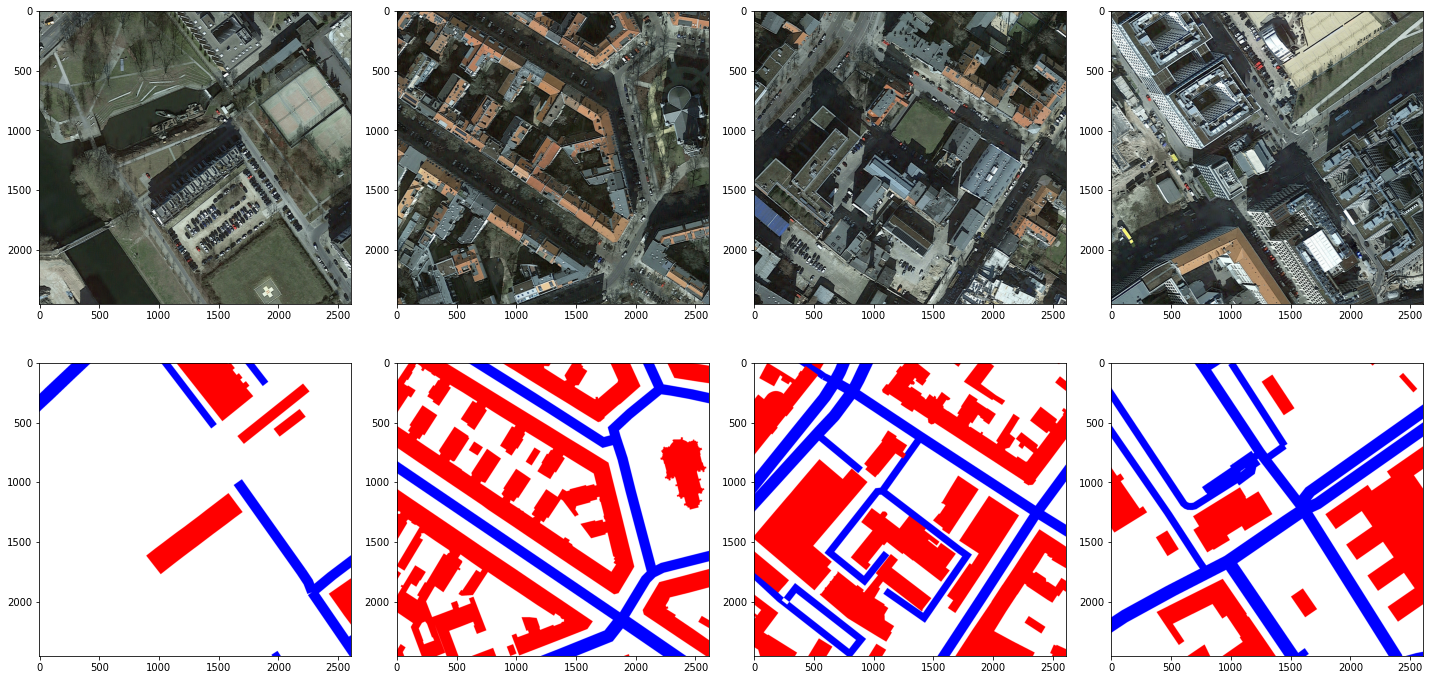

In [6]:
plt.figure(figsize=(20, 10))
for i, f in enumerate(np.random.randint(1, 200, 4)):
  plt.subplot(2,4, i+1)
  plt.imshow(Image.open(os.path.join(path, city, f'{city}{f}_image.png')))
  plt.subplot(2,4,4+i+1)
  plt.imshow(Image.open(os.path.join(path, city, f'{city}{f}_labels.png')))

plt.tight_layout()

In [37]:
label0 = Image.open(os.path.join(path, city, f'{city}2_labels.png'))
label0 = np.array(label0)

In [8]:
label0.shape

(2453, 2610, 3)

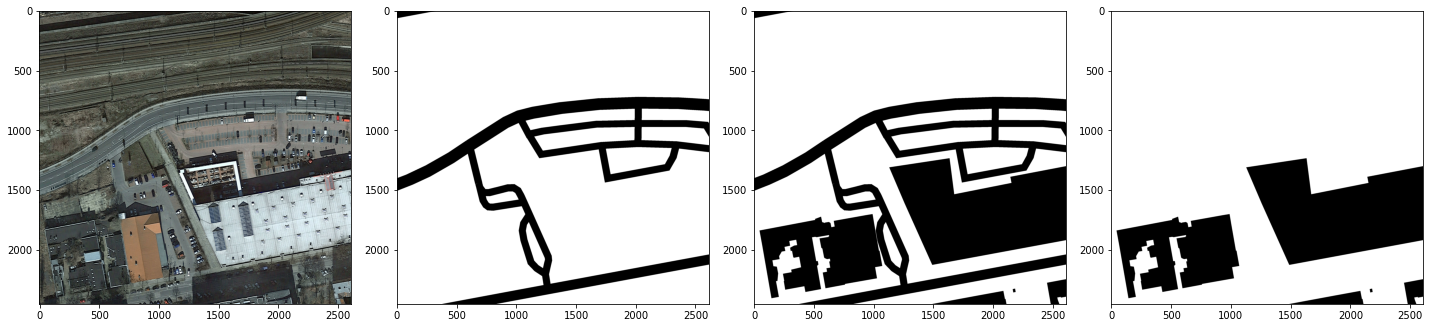

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(Image.open(os.path.join(path, city, f'{city}2_image.png')))
plt.subplot(1,4,2)
plt.imshow(label0[:,:,0], cmap='gray')

plt.subplot(1,4,3)
plt.imshow(label0[:,:,1], cmap='gray')

plt.subplot(1,4,4)
plt.imshow(label0[:,:,2], cmap='gray')
plt.tight_layout()

In [66]:
label0 = Image.open(os.path.join(path, city, f'{city}7_labels.png'))
label0 = np.array(label0)

In [65]:
def correct_label(label):
  label[:,:,0] = np.where(np.logical_and((label[:,:,1]==0), (label[:,:,2]==0)), 255, 0)
  label[:,:,2] = np.where(label[:,:,1]==255, 0, 255)
  label[:,:,1] = 0
  label[:,:,2] = np.where(label[:,:,0]==255,0, label[:,:,2])
  return label

In [67]:
label_c = correct_label(label0)

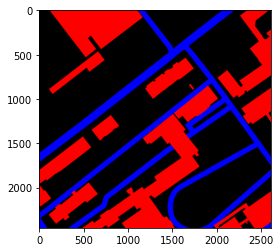

In [68]:
plt.imshow(label_c)

In [ ]:
img = Image.open(os.path.join(path, city, f'{city}2_image.png'))
img = np.array(img)
img.mean()

94.49214291255423

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from tqdm.notebook import tqdm

In [71]:
class Berlin(Dataset):
  def __init__(self, path, city, transforms):
    self.path = path
    self.city = city
    self.transforms = transforms

  def __len__(self):
    return len(os.listdir(os.path.join(self.path, self.city))) //2

  def __getitem__(self, id):
    img = Image.open(os.path.join(self.path, self.city, f'{self.city}{id+1}_image.png'))
    label = Image.open(os.path.join(self.path, self.city, f'{self.city}{id+1}_labels.png'))
    img = np.array(img)/255.0
    img = torch.tensor(img).permute(2,0,1)
    img = self.transforms['image'](img)
    label = self.transforms['label'](label)
    label = self.correct_label(label)
    label = torch.tensor(label) /255.0
    label = label.permute(2,0,1)
    x_min = np.random.randint(0, label.shape[1]//4)
    y_min = np.random.randint(0, label.shape[2]//4)
    x_max = x_min + label.shape[1] // 4
    y_max = y_min + label.shape[2] // 4
    img = img[:, x_min:x_max, y_min:y_max]
    label = label[:, x_min:x_max, y_min:y_max]
    return img, label

  def correct_label(self, label):
    label = np.array(label)
    label[:,:,0] = np.where(np.logical_and((label[:,:,1]==0), (label[:,:,2]==0)), 255, 0)
    label[:,:,2] = np.where(label[:,:,1]==255, 0, 255)
    label[:,:,1] = 0
    label[:,:,2] = np.where(label[:,:,0]==255,0, label[:,:,2])
    return label


In [72]:
img_transforms = T.Compose([T.Resize((2452, 2610)), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
label_transforms = T.Compose([T.Resize((2452, 2610))])
transforms= {'image':img_transforms, 'label':label_transforms}

In [73]:
berlin_ds = Berlin(path, city, transforms)

In [134]:
train_dataset, test_dataset = torch.utils.data.random_split(berlin_ds, [120,80])
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [135]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
unnormalizer = UnNormalize(mean, std)

In [136]:
def train(model, optimizer, criterion, lr_scheduler, loaders, epochs=10):
  loss_history = []
  for epoch in range(epochs):
    model = model.train()
    pbar = tqdm(loaders['train_loader'])
    epoch_loss = np.array([])
    for images, labels in pbar:
      images = images.to(device).float()
      labels = labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], labels)
      loss.backward()
      optimizer.step()
      epoch_loss = np.append(epoch_loss, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{epochs}, loss= {epoch_loss.mean():.5f}')
    
    loss_history.append(epoch_loss.mean())
    lr_scheduler.step()
    with torch.no_grad():
      model.eval()
      test_samples = next(iter(loaders['test_loader']))
      out = model(test_samples[0].to(device).float())
      plt.figure(figsize=(15,5))
      plt.subplot(1,3,1)
      plt.imshow(unnormalizer(test_samples[0][0].cpu()).permute(1,2,0))
      plt.title('image')
      plt.subplot(1,3,2)
      plt.imshow(test_samples[1][0].permute(1,2,0).cpu())
      plt.title('ground truth')
      plt.subplot(1,3,3)
      plt.imshow(out['out'][0].permute(1,2,0).cpu())
      plt.title('predicted mask')
      plt.show()
  return model, loss_history

In [137]:
from SegLoss.losses_pytorch import dice_loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=3)
model = model.to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = dice_loss.TverskyLoss()
loaders = {'train_loader':train_loader, 'test_loader':test_loader}

cuda


In [138]:
model, loss_history = train(model, optimizer, criterion, lr_scheduler, loaders, epochs=30)

KeyboardInterrupt: ignored

In [132]:

with open('model.pt', 'wb') as f:
  torch.save(model, f)
!cp model.pt drive/MyDrive/aerial_image_segmentation/

In [ ]:
def test(test_loader):
  with torch.no_grad():
    model.eval()
    test_losses = []
    preds = []
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      out = model(images)
      preds.append(out)
      loss = criterion(out['out'], labels)
      test_losses.append(loss.item())
  return preds, test_losses

In [ ]:
preds, test_losses = test(test_loader)

In [ ]:
len(preds)

80

In [ ]:
preds[0]['out'].shape

torch.Size([1, 3, 613, 652])

In [ ]:
x = preds[0]['out'][0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


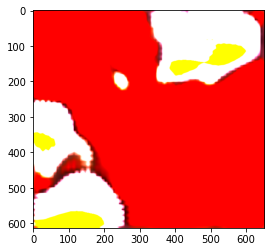

In [ ]:
plt.imshow(x)

In [ ]:
i,l = test_dataset[0]

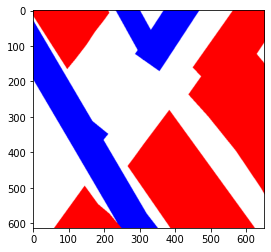

In [ ]:
plt.imshow(l.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


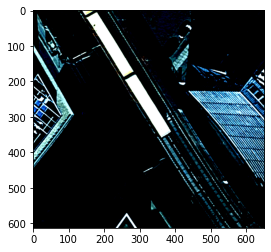

In [ ]:
plt.imshow(i.permute(1,2,0))